# Project Description

### TODO
#### We are using a CNN, max pooling, and n-grams (a sequence of n words in a sentence) to construct this project

## Imporant Documentation

### PyTorch Resources:
#####    - https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html
#####    - https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html
#####    - https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html
#####    - https://pytorch.org/docs/stable/generated/torch.nn.MaxPool1d.html
#####    - https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
#####    - https://towardsdatascience.com/understanding-word-n-grams-and-n-gram-probability-in-natural-language-processing-9d9eef0fa058#:~:text=An%20N%2Dgram%20means%20a,3%2Dgram%20(trigram).

### Step 0: Import Libraries

In [148]:
import re
import nltk
import math
import copy
import torch
import numpy as np
import pandas as pd
import seaborn as sn
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
TRAINING_MODE = True

### Step 1: Tokenize data and build vocab

In [149]:
class Preprocessing:
    def __init__(self, vocab_size, seq_len):
        self.file_name = 'clickbait_data.csv'
        self.vocab_size = vocab_size
        self.seq_len = seq_len
        self.vocab = None
        self.x_tokenized = None
        self.x_padded = None
        self.x = None
        self.y = None

        self.x_train = None
        self.x_test = None
        self.y_train = None
        self.y_test = None

    def load_dataset(self):
        # Load dataset from local directory 
        df = pd.read_csv(self.file_name)
        df = shuffle(df)
        self.x = df['headline'].to_numpy()
        self.y = df['clickbait'].to_numpy()

    def clean_data(self):
        # Clean data by removing all special characters. Convert words to lowercase
        self.x = [re.sub(r'\'','', headline).lower() for headline in self.x]
        self.x = [re.sub(r'[^A-Za-z0-9]+',' ', headline).lower() for headline in self.x]

    def tokenization(self):
        # Tokenize all headlines
        self.x = [nltk.tokenize.wordpunct_tokenize(headline) for headline in self.x]

    def build_vocab(self):
        # Build vocab and return 'vocab_size' most common words
        self.vocab = dict()

        fdist = nltk.FreqDist()
        for headline in self.x:
            for word in headline:
                fdist[word] += 1
        
        common_words = fdist.most_common(self.vocab_size)

        for count, word in enumerate(common_words):
            self.vocab[word[0]] = count+1
    
    def word_to_idx(self):	
        # Convert each token into index based representation 
        self.x_tokenized = list()
        
        for sentence in self.x:
            temp = list()
            for word in sentence:
                if word in self.vocab.keys():
                    temp.append(self.vocab[word])
            self.x_tokenized.append(temp)
    
    def padding_sentences(self):
        # Make all sentences equal length. 
        # If sentence is smaller than minimum length, pad it 
        idx = 0
        self.x_padded = list()

        for sentence in self.x_tokenized:
            while len(sentence) < self.seq_len:
                sentence.insert(len(sentence), idx)
            while len(sentence) > self.seq_len:
                print("Sentence is long, consider increasing the sequence length to prevent vocab dropping.")
                sentence.pop()
            self.x_padded.append(sentence)
            
        self.x_padded = np.array(self.x_padded)

    def split_data(self):
        # Split data into training and testing sets
        trnSize = int(len(self.x_padded) * .8)
        tstSize = int(len(self.x_padded) * .2)
        self.x_train = self.x_padded[:trnSize]
        self.y_train = self.y[:trnSize]
        self.x_test = self.x_padded[trnSize:]
        self.y_test = self.y[trnSize:]
    
    def get_tokenized_string(self, sentence) -> list:
        # Load dataset from local directory 
        string = sentence
        string = re.sub(r'\'','', string).lower()
        string = re.sub(r'[^A-Za-z0-9]+',' ', string).lower()
        string = nltk.tokenize.wordpunct_tokenize(string)
        x_tokenized = list()
        idx = 0
        for word in string:
            if word in self.vocab.keys():
                x_tokenized.append(self.vocab[word])
        while len(x_tokenized) < self.seq_len:
            x_tokenized.insert(len(string), idx)
        while len(x_tokenized) > self.seq_len:
            print("Sentence is long, consider increasing the sequence length to prevent vocab dropping.")
            x_tokenized.pop()
        x_padded = x_tokenized
        return np.array([x_padded])


### Step 2: Build the Model

In [150]:
class HeadlineClassifier(torch.nn.ModuleList):
    def __init__(self, seq_len, num_words, embedding_size, dropout, out_size, stride, filters):
        super(HeadlineClassifier, self).__init__()

        self.seq_len = seq_len
        self.num_words = num_words
        self.embedding_size = embedding_size

        # Dropout (used to reduce chance of overfitting by "dropping" units in neural net). Probability (p) set to 0.25
        self.dropout = torch.nn.Dropout(dropout)

        # Kernel sizes for CNN
        #pass it as params when we change the implmentation. Can keep it like this for now
        self.filters = filters

        # Output size for convolutions
        self.out_size = out_size
        # Number of strides for convolutions
        self.stride = stride

        # Embedding layer (lookup table that stores embeddings of a fixed dictionary and size)
        self.embedding = torch.nn.Embedding(self.num_words + 1, self.embedding_size, padding_idx=0).cuda()

        # Convolution layers (each is a 1D convolution over an input)
        self.clayers = [torch.nn.Conv1d(self.seq_len, self.out_size, fltr, self.stride) for fltr in self.filters]
        for layer in self.clayers:
            layer = layer.cuda()
        
            
        # Max pooling layers (each applies 1D max pooling to input) 
        self.poollayers = [torch.nn.MaxPool1d(fltr, self.stride) for fltr in self.filters]
        for layer in self.poollayers:
            layer = layer.cuda()

        # Fully connected layer (applies linear transformation to data)
        self.fc = torch.nn.Linear(self.size_of_input(), 1)

        # Evaluation metrics
        self.train_eval_info = {
            "accuracy": 0,
            "precision": 0,
            "recall": 0,
            "tpr": 0,
            "fpr": 0,
            "tp": 0,
            "fp": 0,
            "tn": 0,
            "fn": 0
        }

        self.test_eval_info = {
            "accuracy": 0,
            "precision": 0,
            "recall": 0,
            "tpr": 0,
            "fpr": 0,
            "tp": 0,
            "fp": 0,
            "tn": 0,
            "fn": 0
        }

    
    def size_of_input(self):
        # Calculate input size for linear layer 
        pout = 0
        for filter in self.filters:
            cout = math.floor(((self.embedding_size - (filter - 1) - 1)/self.stride) + 1)
            pout += math.floor(((cout - (filter - 1) - 1) / self.stride) + 1)
        
        return pout * self.out_size

    '''Create forward pass of neural network. Consists of mainly ordering the different types of layers
        Steps:
            1. Pass tokenized words through embedding layer
            2. Pass each embedded sentence through each convolution and max pooling layer
            3. Reduce vector to linear layer
    '''
    def forward(self, input_X):
        x = self.embedding(input_X)

        layerPasses = list()
        for i in range(len(self.filters)):
            temp = self.clayers[i](x)
            #TODO: Why not sigmoid (there are a few common functions we can try)? Maybe this can be a question we answer
            temp = torch.relu(temp).cuda()
            temp = self.poollayers[i](temp)
            layerPasses.append(temp)

        unn = torch.cat(layerPasses, 2)
        unn = unn.reshape(unn.size(0), -1)

        output = torch.sigmoid(self.dropout(self.fc(unn))).squeeze()
        return output


### Step 3: Train Model

In [151]:
# Train model
# Returns: Training Loss, Testing Loss, Training Accuracy, Testing Accuracy, Evaluated Training List, Evaluated Testing List
def train(model, dataset, learning_rate, batch_size, train_data, test_data, numOfIter):
    train_loader = torch.utils.data.DataLoader(train_data, batch_size)
    # for x, y in train_loader:
    #         x = x.to('cuda')
    #         y = y.type(torch.FloatTensor)
    #         y = y.to('cuda')

    test_loader = torch.utils.data.DataLoader(test_data, batch_size)
    # for x, y in test_loader:
    #         x = x.to('cuda')
    #         y = y.to('cuda')

    opt = torch.optim.SGD(model.parameters(), lr = learning_rate)

    trainLoss, testLoss, trainAccuracy, testAccuracy = [], [], [], []
    for iter in range(numOfIter):
        model.train()
        train_predictions = []

        for x,y in train_loader:
            y = y.type(torch.cuda.FloatTensor)
            pred = model.forward(x) # Forward pass on input data
            loss = torch.nn.functional.binary_cross_entropy(pred, y) # Measure the Binary Cross Entropy between the target and input probabilities

            opt.zero_grad() # Set gradients to zero 

            loss.backward()

            opt.step()

            train_predictions += list(pred.cpu().detach().numpy()) # Append training predictions 

        # Evaluate model
        model.eval() # Put model in evaluation mode
        test_predictions = []
        with torch.no_grad(): # Disable gradient calculation 
            for x, y in test_loader:
                pred = model.forward(x)
                test_predictions += list(pred.cpu().detach().numpy()) # Append test predictions

        # Get model accuracy 
        # train_eval = [accuracy, precision, recall, true-positive-rate, false-positive-rate, true_pos, false_pos, true_neg, false_neg]
        train_eval = evaluate(dataset.y_train, train_predictions)
        test_eval = evaluate(dataset.y_test, test_predictions)
        train_loss = loss.item()
        test_loss = loss.item()
        
        # Gather training and testing loss & accuracy
        trainLoss.append(train_loss)
        testLoss.append(test_loss)
        trainAccuracy.append(train_eval[0])
        testAccuracy.append(test_eval[0])
        
        # Print training and testing accuracy for each iteration
        print("Training -- Iteration: %d, Loss: %.5f, Accuracy: %.5f, Precision: %.5f, Recall: %.5f, TPR: %.5f, FPR: %.5f" % (iter+1, train_loss, train_eval[0], train_eval[1], train_eval[2], train_eval[3], train_eval[4]))
        print("Testing -- Iteration: %d, Loss: %.5f, Accuracy: %.5f, Precision: %.5f, Recall: %.5f, TPR: %.5f, FPR: %.5f" % (iter+1, test_loss, test_eval[0], test_eval[1], test_eval[2], test_eval[3], test_eval[4]))

    # Update model's evaluation metrics
    model.train_eval_info['trn_accuracy'] = trainAccuracy
    model.train_eval_info['precision'] = train_eval[1]
    model.train_eval_info['recall'] = train_eval[2]
    model.train_eval_info['tpr'] = train_eval[3]
    model.train_eval_info['fpr'] = train_eval[4]
    model.train_eval_info['tp'] = train_eval[5]
    model.train_eval_info['fp'] = train_eval[6]
    model.train_eval_info['tn'] = train_eval[7]
    model.train_eval_info['fn'] = train_eval[8]

    model.test_eval_info['trn_accuracy'] = trainAccuracy
    model.test_eval_info['precision'] = train_eval[1]
    model.test_eval_info['recall'] = train_eval[2]
    model.test_eval_info['tpr'] = train_eval[3]
    model.test_eval_info['fpr'] = train_eval[4]
    model.test_eval_info['tp'] = train_eval[5]
    model.test_eval_info['fp'] = train_eval[6]
    model.test_eval_info['tn'] = train_eval[7]
    model.test_eval_info['fn'] = train_eval[8]

    return (trainLoss, testLoss)
        

### Step 4: Build Supporting Classes and Functions

In [152]:
class DataClass(torch.utils.data.TensorDataset):
   def __init__(self, x, y):
      self.x = x
      self.y = y
      
   def __len__(self):
      return len(self.x)
      
   def __getitem__(self, idx):
      return self.x[idx], self.y[idx]

In [153]:
# Get accuracy of model 
# Returns Accuracy, Precision, Recall, True-Positive-Rate, False-Positive-Rate
def evaluate(actual, predictions):
    true_pos = 0
    false_pos = 0
    true_neg = 0
    false_neg = 0

    for true, pred in zip(actual, predictions):
        if (pred >= .5) and (true == 1): # True positive (prediction is 'clickbait' and actual is 'clickbait')
            true_pos += 1
        elif (pred >= .5) and (true == 0): # False positive (prediction is 'clickbait' and actual is 'not clickbait')
            false_pos += 1
        elif (pred < .5) and (true == 0): # True negative (prediction is 'not clickbait' and actual is 'not clickbait')
            true_neg += 1
        elif (pred < .5) and (true == 1): # False negative (prediction is 'not clickbait' and actual is 'clickbait')
            false_neg += 1

    # Return accuracy of model
    accuracy = (true_pos + true_neg) / len(actual)
    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    true_pos_rate = true_pos / (true_pos + false_neg)
    false_pos_rate = false_pos / (false_pos + true_neg)

    return [accuracy, precision, recall, true_pos_rate, false_pos_rate, true_pos, false_pos, true_neg, false_neg]


In [154]:
def confusion_matrix(tp, fp, tn, fn):
    arr = [[tp, fn],
           [fp, tn]]
    df_cm = pd.DataFrame(arr, range(6), range(6))
    plt.figure(figsize=(10,7))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.show()
    

### Step 5: Run Model!

In [155]:
# Initialization variables
seq_len = 30

# Initialize instance of Preprocessing class
dataset = Preprocessing(100_000, seq_len)

# Load dataset
dataset.load_dataset()

# Clean and tokenize dataset
dataset.clean_data()
dataset.tokenization()

# Build vocab 
dataset.build_vocab()

# Index words and pad headline sentences
dataset.word_to_idx()
dataset.padding_sentences()

# Split data into training and testing sets
dataset.split_data()

# Print data specifics:
print("Dataset size: ", len(dataset.x))
#print("Dataset vocab: ", dataset.vocab)
print("Dataset training size: ", len(dataset.y_train))
print("Dataset testing size: ", len(dataset.x_test))

# Initialize model (TODO: optimize parameters)
vocab_size = len(dataset.vocab)
embedding_size = 64
dropout = 0.25
out_size = 40
stride = 2
filters = [2,3,4,5]
model = HeadlineClassifier(seq_len, vocab_size, embedding_size, dropout, out_size, stride, filters)

# Model save paths model
save_path = Path("model-save-data/model.pth")
cpu_flag_path = Path("model-save-data/cpu")
gpu_flag_path = Path("model-save-data/gpu")

Dataset size:  32000
Dataset training size:  25600
Dataset testing size:  6400


--------------Found CUDA device. Training on GPU.--------------
Training -- Iteration: 1, Loss: 0.47143, Accuracy: 0.66086, Precision: 0.62664, Recall: 0.78636, TPR: 0.78636, FPR: 0.46322
Testing -- Iteration: 1, Loss: 0.47143, Accuracy: 0.77484, Precision: 0.76683, Recall: 0.80410, TPR: 0.80410, FPR: 0.25575
Training -- Iteration: 2, Loss: 0.23860, Accuracy: 0.70859, Precision: 0.66751, Recall: 0.82455, TPR: 0.82455, FPR: 0.40604
Testing -- Iteration: 2, Loss: 0.23860, Accuracy: 0.79453, Precision: 0.80819, Recall: 0.78423, TPR: 0.78423, FPR: 0.19469
Training -- Iteration: 3, Loss: 0.38451, Accuracy: 0.72070, Precision: 0.67704, Recall: 0.83790, TPR: 0.83790, FPR: 0.39517
Testing -- Iteration: 3, Loss: 0.38451, Accuracy: 0.79312, Precision: 0.76700, Recall: 0.85513, TPR: 0.85513, FPR: 0.27174
Training -- Iteration: 4, Loss: 0.15226, Accuracy: 0.72840, Precision: 0.68335, Recall: 0.84545, TPR: 0.84545, FPR: 0.38732
Testing -- Iteration: 4, Loss: 0.15226, Accuracy: 0.80359, Precision: 0

KeyError: 'trainAccuracy'

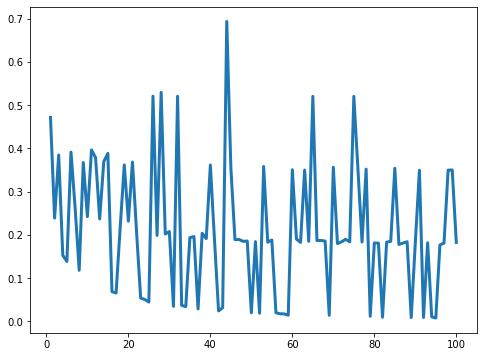

In [156]:
if TRAINING_MODE:
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    if device == 'cuda':
        print("--------------Found CUDA device. Training on GPU.--------------")
    else:
        print("--------------Training on CPU--------------")
    model = model.to(device)

    # Creating testing and training datasets
    train_set = torch.utils.data.TensorDataset(torch.Tensor(dataset.x_train).long().cuda(), torch.Tensor(dataset.y_train).long().cuda())
    test_set = torch.utils.data.TensorDataset(torch.Tensor(dataset.x_test).long().cuda(), torch.Tensor(dataset.y_test).long().cuda())

    # Train model
    learning_rate = 0.01
    batch_size = 12
    numOfIter = 100
    trainLoss, testLoss = train(model, dataset, learning_rate, batch_size, train_set, test_set, numOfIter)

    # Delete old save data
    if save_path.exists():
        save_path.unlink()
    if cpu_flag_path.exists():
        cpu_flag_path.unlink()
    if gpu_flag_path.exists():
        gpu_flag_path.unlink()

    # Write save and training device marker
    torch.save(model.state_dict(), save_path)
    if device == 'cuda':
        Path(gpu_flag_path).touch()
    else:
        Path(cpu_flag_path).touch()

    #plot losses/accuracies
    x = list(range(1, numOfIter + 1))
    fig, ax = plt.subplots(figsize=(8,6))
    plt.plot(x, trainLoss, label='Training Loss', color='tab:blue', linewidth=3)
    plt.plot(x, model.train_eval_info['trn_accuracy'], label='Training Accuracy', color='tab:green', linewidth=3)
    plt.title('Training Loss and Accuracy')
    plt.legend(fancybox=True, framealpha=0.5, fontsize=18)
    plt.show()

    fig, ax = plt.subplots(figsize=(8,6))
    plt.plot(x, testLoss, label='Testing Loss', color='tab:blue', linewidth=3)
    plt.plot(x, model.test_eval_info['trn_accuracy'], label='Testing Accuracy', color='tab:green', linewidth=3)
    plt.title('Testing Loss and Accuracy')
    plt.legend(fancybox=True, framealpha=0.5, fontsize=18)
    plt.show()

    # Plot confusion matrix
    # trainEval = [accuracy, precision, recall, true-positive-rate, false-positive-rate, true_pos, false_pos, true_neg, false_neg]
    confusion_matrix(model.train_eval_info['tp'], model.train_eval_info['fp'], model.train_eval_info['tn'], model.train_eval_info['fn'])

In [163]:
save_device = 'cuda' if Path(gpu_flag_path).exists() else 'cpu'
my_device = 'cpu' #'cuda' if torch.cuda.is_available() else 'cpu'
model = HeadlineClassifier(seq_len, vocab_size, embedding_size, dropout, out_size, stride, filters)
if save_device == 'cuda' and my_device == 'cpu':
    model.load_state_dict(torch.load(save_path, map_location=my_device))
elif save_device == 'cuda' and my_device == 'cuda':
    model.load_state_dict(torch.load(save_path))
    model.to(my_device)
elif save_device == 'cuda' and my_device == 'cuda':
    model.load_state_dict(torch.load(save_path, map_location="cuda:0"))
    model.to(device)
else:
    model.load_state_dict(torch.load(save_path))
    
model.eval()


HeadlineClassifier(
  (dropout): Dropout(p=0.25, inplace=False)
  (embedding): Embedding(23328, 64, padding_idx=0)
  (fc): Linear(in_features=2320, out_features=1, bias=True)
)

In [164]:
#Run a prediction test
def predict(string) -> float:
    test_phrase = dataset.get_tokenized_string(string)
    with torch.no_grad(): # Disable gradient calculation
        pred = model(torch.tensor(test_phrase))
        return pred.detach().numpy()

prediction = predict("How I became a millionare")
if prediction > 0.5:
    print("CLICKBAIT FOUND ( result =", prediction, ")")
else:
    print("Not clickbait ( result =", prediction, ")")

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument weight in method wrapper__thnn_conv2d_forward)